# Load packages

In [4]:
from hydromt_wflow import WflowModel
import matplotlib.pyplot as plt 
import toml
import pandas as pd

C:\Users\creeb\anaconda3\envs\BPD4a\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\creeb\anaconda3\envs\BPD4a\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Load model

In [11]:
root = r"C:\Users\creeb\Wflow_mod\for_nienke_mike"
config_fn = "wflow_flextopo.toml"
mod = WflowModel(root = root, config_fn = config_fn, mode = "r")
ds = mod.staticmaps


In [12]:
plt.figure(); ds["sumax"].sel(classes="w").raster.mask_nodata().plot()
plt.figure(); ds["sumax"].sel(classes="p").raster.mask_nodata().plot()
plt.figure(); ds["sumax"].sel(classes="h").raster.mask_nodata().plot()

KeyError: 'sumax'

<Figure size 640x480 with 0 Axes>

## Change runtime

In [4]:
# Modify the starttime and endtime
mod.config['starttime'] = '1999-01-01T00:00:00'
mod.config['endtime'] = '2018-12-31T00:00:00'
mod.config

{'casename': 'wflow_meuse',
 'calendar': 'proleptic_gregorian',
 'starttime': '1999-01-01T00:00:00',
 'endtime': '2018-12-31T00:00:00',
 'time_units': 'days since 1900-01-01 00:00:00',
 'timestepsecs': 86400,
 'silent': False,
 'loglevel': 'debug',
 'path_log': 'log.txt',
 'fews_run': False,
 'state': {'path_input': 'instate/instates.nc',
  'path_output': 'outstate/outstates.nc',
  'lateral': {'river': {'reservoir': {'volume': 'volume_reservoir'},
    'q': 'q_river',
    'h': 'h_river',
    'h_av': 'h_av_river'},
   'land': {'q': 'q_land', 'h': 'h_land', 'h_av': 'h_av_land'}},
  'vertical': {'snow': 'snow',
   'snowwater': 'snowwater',
   'interceptionstorage': 'interceptionstorage',
   'hortonpondingstorage': 'hortonpondingstorage',
   'hortonrunoffstorage': 'hortonrunoffstorage',
   'rootzonestorage': 'rootzonestorage',
   'faststorage': 'faststorage',
   'slowstorage': 'slowstorage'}},
 'input': {'path_forcing': '../inmaps/eobs_v20_1980_2018_corrP_remapnn_semisstonn.nc',
  'path_sta

## Load Srmax values

In [5]:
gdf = mod.staticgeoms["subcatch_Sall"].copy()
gdf.index = gdf["wflow_subcatch_Sall"]
gdf = gdf.drop(columns="wflow_subcatch_Sall")

In [6]:
gdf
wflow_ids = gdf.loc[gdf['geometry'] != None].index.values

In [7]:
# mod.staticgeoms["subcatch_Sall"].plot(edgecolor="k");

In [8]:
mod.staticgeoms["subcatch_Sall"];

In [9]:
for v in range(1, 51):
    SRmax_v = pd.read_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/9_TOML/1_Input/SRpandas/SRmax_{v}.csv')
    for i in range(len(gdf)):
        wflow = gdf.index[i]
        wflow_int=int(wflow)
        subcatch = gdf.iloc[i]
        if wflow_int in wflow_ids:
            if wflow_int in SRmax_v['WFLOW'].values:
                gdf.loc[wflow_int, 'sumax_w'] = SRmax_v.loc[SRmax_v['WFLOW'] == wflow_int, 'Sr_2'].values
                gdf.loc[wflow_int, 'sumax_p'] = SRmax_v.loc[SRmax_v['WFLOW'] == wflow_int, 'Sr_2'].values
                gdf.loc[wflow_int, 'sumax_h'] = SRmax_v.loc[SRmax_v['WFLOW'] == wflow_int, 'Sr_20'].values

            else:
                gdf.loc[wflow_int, 'sumax_w'] = SRmax_v.loc[SRmax_v['WFLOW'] == 16, 'Sr_2'].values
                gdf.loc[wflow_int, 'sumax_p'] = SRmax_v.loc[SRmax_v['WFLOW'] == 16, 'Sr_2'].values
                gdf.loc[wflow_int, 'sumax_h'] = SRmax_v.loc[SRmax_v['WFLOW'] == 16, 'Sr_20'].values
                
    sumax_w = ds["sumax"].raster.rasterize(gdf, col_name="sumax_w")
    sumax_p = ds["sumax"].raster.rasterize(gdf, col_name="sumax_p")
    sumax_h = ds["sumax"].raster.rasterize(gdf, col_name="sumax_h")

    #make a copy of sumax maps in staticmaps
    sumax_v_classes = ds["sumax"].copy()
    
    #overwrite sumax plateau class with new values
    sumax_v_classes.loc[dict(classes="p")] = sumax_p

    #overwrite sumax wetland class with new values
    sumax_v_classes.loc[dict(classes="w")] = sumax_w

    #overwrite sumax hillslope class with new values
    sumax_v_classes.loc[dict(classes="h")] = sumax_h
    
    #add the new sumax maps to the staticmaps
    sumax_v_classes.name = "sumax_v"
    
    mod.set_staticmaps(sumax_v_classes)
    mod.set_config("input.vertical.srmax","sumax_v")
    mod.set_config("input.path_static", "staticmaps_flex_meuse.nc")
    mod.set_config("input.path_forcing", "../for_nienke_mike/inmaps/eobs_v20_1980_2018_corrP_remapnn_semisstonn.nc")
    mod.staticmaps.raster.set_crs("EPSG:4326")
    
    mod.set_root(f"C:/Users/Nienke Tempel/Documents/Thesis/11. Model/Model/flextopo_update_sumax_{v}")
    mod.write_staticmaps()
    mod.write_config()
    mod.write_staticgeoms()

In [10]:
# mod.staticmaps

## Check if maps is right

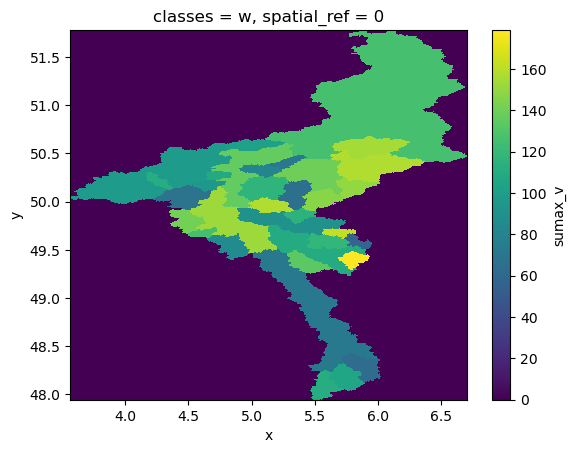

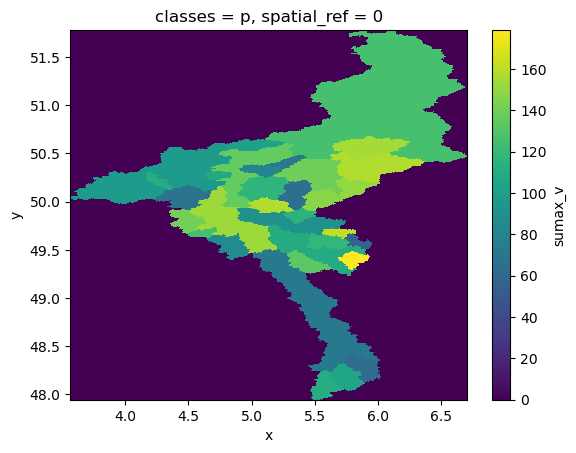

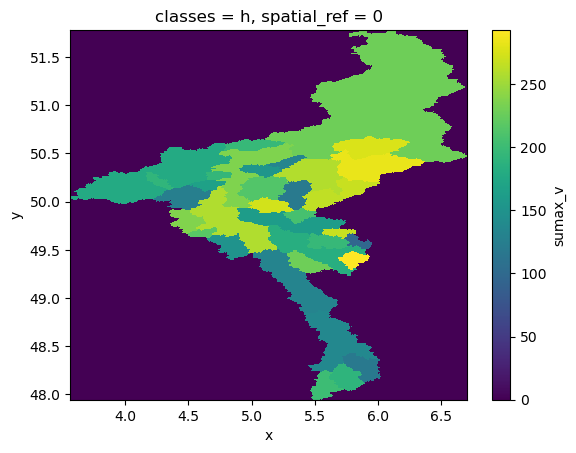

In [11]:
plt.figure(); sumax_v_classes.sel(classes="w").raster.mask_nodata().plot()
plt.figure(); sumax_v_classes.sel(classes="p").raster.mask_nodata().plot()
plt.figure(); sumax_v_classes.sel(classes="h").raster.mask_nodata().plot()